# Bayesian Logistic Regression for Elo Prediction

## 1. Load and Preprocess Data

In [1]:
import pymc as pm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from utils import *

df = load_dataframe(path="../data/final_data_30_shards")
df = df.fillna(0.0)
df = df.iloc[:10000]

y_reg_avg = df[['WhiteElo', 'BlackElo']].mean(axis=1)
y_clf_avg = pd.qcut(y_reg_avg, q=10, labels=False, duplicates='drop')

categorical = df[['Termination', "ECO"]]
X = df.drop(columns=['WhiteElo', 'BlackElo', 'Result', 'Opening', 'Termination', "ECO"])

X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)

categorical_OHE = pd.get_dummies(categorical, columns=['ECO', 'Termination'], drop_first=False)
X_final = X_scaled.join(categorical_OHE)

result = remove_collinear_features(X_final, corr_threshold=0.95)
print("Kept features:", result["selected_features"])
print("Removed log:", result["removed_features"])
X_final = result["reduced_df"]


corr_matrix = X_scaled.corr()
threshold = 0.9
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [
    (col1, col2)
    for col1 in upper_tri.columns
    for col2 in upper_tri.index
    if abs(upper_tri.loc[col2, col1]) > threshold
]
to_drop = set()
for col1, col2 in high_corr_pairs:
    corr1 = abs(np.corrcoef(X_scaled[col1], y_reg_avg)[0, 1])
    corr2 = abs(np.corrcoef(X_scaled[col2], y_reg_avg)[0, 1])
    drop_feature = col1 if corr1 < corr2 else col2
    to_drop.add(drop_feature)

X_scaled_reduced = X_scaled.drop(columns=to_drop)
X_final_reduced = X_scaled_reduced.join(categorical_OHE)

#y_binary = (y_clf_avg >= y_clf_avg.median()).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_final_reduced.values,
    y_clf_avg.values,
    test_size=0.3,
    random_state=42
)

# Ensure data types are correct for PyMC
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

#unique, counts = np.unique(y_train, return_counts=True)
#inv_freq = {cls: 1.0/count for cls, count in zip(unique, counts)}
#weights = np.array([inv_freq[y] for y in y_train])

n_classes = 10
n_features = X_train.shape[1]

Kept features: ['parsed_num_moves', 'white_accuracy_cp', 'black_accuracy_cp', 'ECO_white_accuracy_cp_mean', 'ECO_white_accuracy_cp_median', 'ECO_black_accuracy_cp_mean', 'ECO_black_accuracy_cp_median', 'White_white_accuracy_cp_mean', 'White_white_accuracy_cp_median', 'White_white_accuracy_cp_std', 'White_black_accuracy_cp_mean', 'White_black_accuracy_cp_median', 'White_black_accuracy_cp_std', 'moves_before_castle_white', 'moves_before_castle_black', 'legal_move_diff_at_25', 'legal_move_diff_at_50', 'legal_move_diff_at_75', 'legal_move_diff_at_100', 'development_before_white', 'development_before_black', 'center_control_after_5_white', 'unique_pieces_after_10_white', 'unique_pieces_after_10_black', 'blunder_counts_white', 'blunder_counts_black', 'first_blunder_move_white', 'first_blunder_move_black', 'mistake_counts_white', 'mistake_counts_black', 'first_mistake_move_white', 'first_mistake_move_black', 'first_win_opportunity_white', 'first_win_opportunity_black', 'first_opp_win_opportun

In [2]:
with pm.Model() as multiclass_model:
    # Priors for weights and intercept
    weights = pm.Normal("weights", mu=0, sigma=1, shape=(n_features, n_classes))
    intercept = pm.Normal("intercept", mu=0, sigma=1, shape=(n_classes,))

    # Linear combination
    logits = pm.math.dot(X_train, weights) + intercept

    # Likelihood (multiclass)
    y_obs = pm.Categorical("y_obs",
                           logit_p=logits,
                           observed=y_train)

    trace = pm.sample(1000, tune=1000, target_accept=0.9, chains=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [weights, intercept]


Output()

ValueError: Not enough samples to build a trace.

In [16]:
import pymc as pm
import pymc.logprob as lp
import numpy as np

n_classes = 10
n_features = X_train.shape[1]

# Class weights for imbalanced data (optional, based on inverse frequency)
unique, counts = np.unique(y_train, return_counts=True)
inv_freq = {cls: 1.0/count for cls, count in zip(unique, counts)}
weights = np.array([inv_freq[y] for y in y_train])

with pm.Model() as weighted_multiclass_model:
    # Data containers (for switching test/train later if needed)
    X_data = pm.Data("X_data", X_train)
    y_data = pm.Data("y_data", y_train)
    w_data = pm.Data("w_data", weights)

    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10, shape=(n_classes,))
    beta = pm.Normal("beta", mu=0, sigma=10, shape=(n_features, n_classes))

    # Compute logits: shape (n_samples, n_classes)
    logits = pm.math.dot(X_data, beta) + intercept

    # Use Categorical likelihood with logits
    y_dist = pm.Categorical.dist(logit_p=logits)

    # Compute weighted log-likelihood
    log_like = lp.logp(y_dist, y_data)
    weighted_log_like = log_like * w_data
    pm.Potential("weighted_likelihood", pm.math.sum(weighted_log_like))

    # Define softmax probabilities for prediction
    p = pm.Deterministic("p", pm.math.softmax(logits))

    # Sample from posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.9)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3720 seconds.


## 2. Define and Fit Bayesian Logistic Regression Model

In [9]:
import pymc.logprob as lp
with pm.Model() as weighted_logistic_model:
    # Data container for switching between train/test sets
    X_data = pm.Data("X_data", X_train)

    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])

    # Logit and probability
    logits = intercept + pm.math.dot(X_data, beta)

    # Weighted Likelihood using pm.Potential
    y_dist = pm.Bernoulli.dist(logit_p=logits)
    log_like = lp.logp(pm.Categorical.dist(logit_p=logits), y_train).sum()
    pm.Potential('weighted_likelihood', pm.math.sum(log_like * weights))

    # Define a deterministic variable for prediction
    p = pm.Deterministic("p", pm.math.sigmoid(logits))

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, cores=1)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, beta]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7996 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## 3. Evaluate Model

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

# Extract posterior samples for intercept and beta
intercept_samples = trace.posterior['intercept'].stack(sample=("chain", "draw")).values  # shape: (n_classes, n_samples)
beta_samples = trace.posterior['beta'].stack(sample=("chain", "draw")).values  # shape: (n_features, n_classes, n_samples)

# Number of posterior samples
n_posterior_samples = intercept_samples.shape[-1]

# Compute logits and softmax probabilities for each posterior sample on test set
logits_samples = np.zeros((n_posterior_samples, X_test.shape[0], n_classes))

for i in range(n_posterior_samples):
    # logits = X_test @ beta[:, :, i] + intercept[:, i]
    logits_samples[i] = X_test @ beta_samples[:, :, i] + intercept_samples[:, i]

# Softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Apply softmax to logits (over classes axis)
probs_samples = np.array([softmax(logits_samples[i]) for i in range(n_posterior_samples)])  # shape: (n_samples, n_test, n_classes)

# Average over posterior samples to get mean predicted probability
p_pred_mean = probs_samples.mean(axis=0)  # shape: (n_test, n_classes)

# Predicted classes
y_pred = np.argmax(p_pred_mean, axis=1)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Log Loss:", log_loss(y_test, p_pred_mean))


Accuracy: 0.212
Confusion Matrix:
 [[180  34  14  13  10  17  10   4   5   7]
 [113  40  23  18  15  16  15  15  11   9]
 [ 88  33  28  26  14  31  27  18  12  18]
 [ 75  34  27  29  25  20  36  30  21  26]
 [ 44  24  32  24  30  28  35  23  31  37]
 [ 39  25  22  21  24  24  16  33  39  58]
 [ 22  23  15  29  20  29  32  38  27  71]
 [ 21  16  22   9  15  20  36  42  35  97]
 [  6  15  10  12  15  16  18  32  54 121]
 [  2   2   5   3   9   9  13  28  38 177]]
Log Loss: 2.0855263045046115


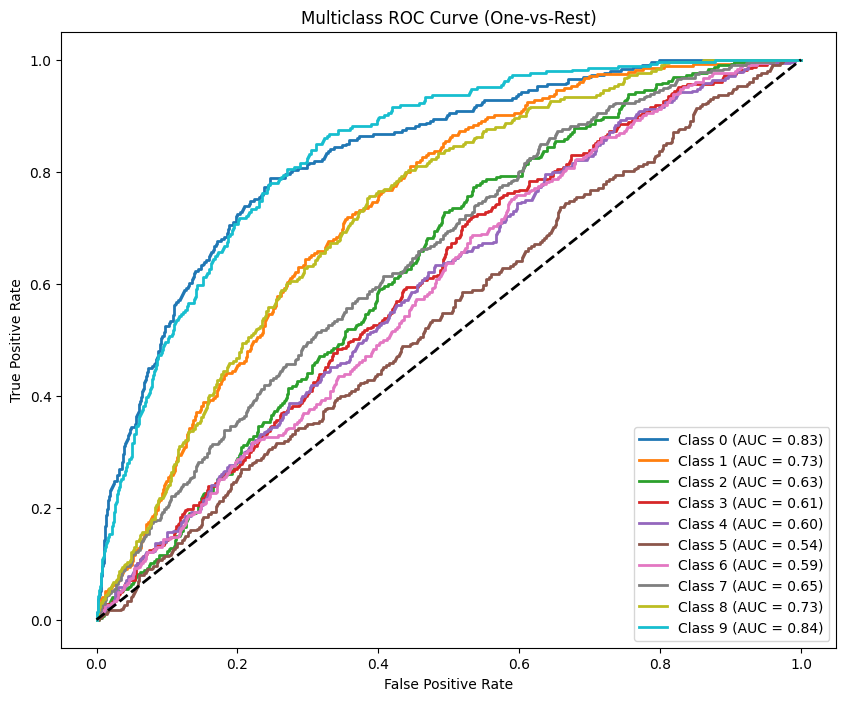

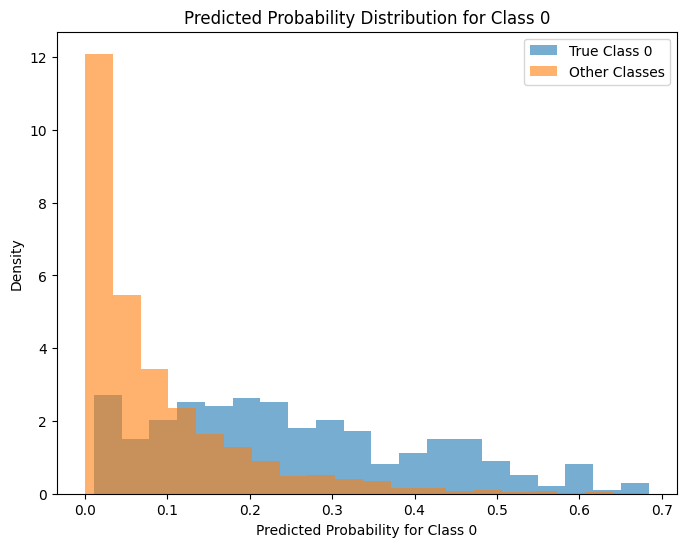

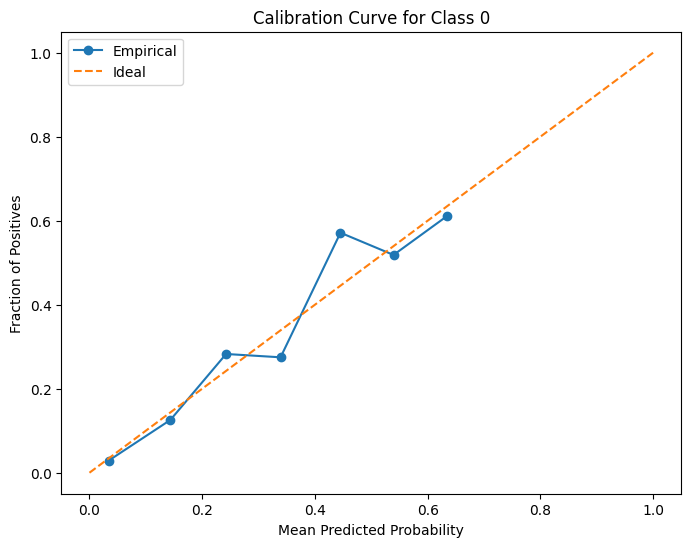

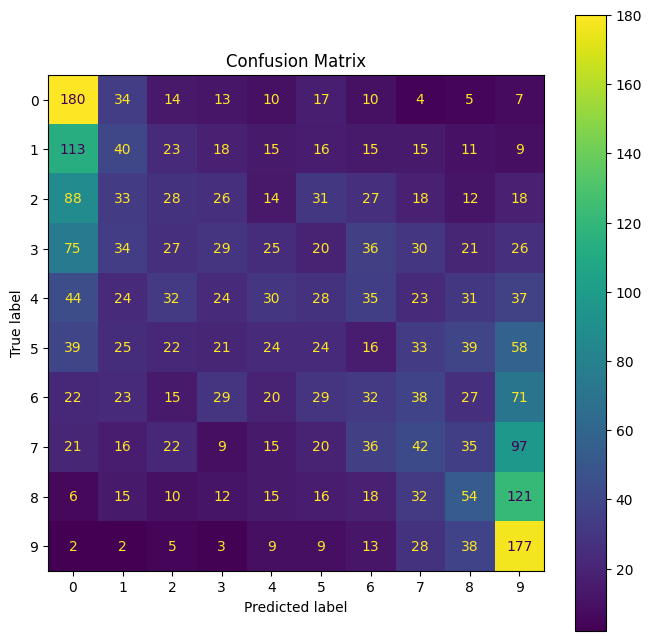

Test Accuracy: 0.212
Macro-average AUC: 0.675


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
import numpy as np

n_classes = p_pred_mean.shape[1]

# Binarize true labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# 1. Multiclass ROC Curves (One-vs-Rest)
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], p_pred_mean[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# 2. Predicted Probability Histograms for a Selected Class (e.g., Class 0)
selected_class = 0
plt.figure(figsize=(8, 6))
plt.hist(p_pred_mean[y_test == selected_class, selected_class], bins=20, alpha=0.6, density=True, label=f'True Class {selected_class}')
plt.hist(p_pred_mean[y_test != selected_class, selected_class], bins=20, alpha=0.6, density=True, label=f'Other Classes')
plt.xlabel(f'Predicted Probability for Class {selected_class}')
plt.ylabel('Density')
plt.title(f'Predicted Probability Distribution for Class {selected_class}')
plt.legend()
plt.show()

# 3. Calibration Curves (for selected class)
plt.figure(figsize=(8, 6))
prob_true, prob_pred = calibration_curve(y_test_bin[:, selected_class], p_pred_mean[:, selected_class], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Empirical')
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve for Class {selected_class}')
plt.legend()
plt.show()

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()

# 5. Summary Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")

# Optional: Macro-average AUC
all_aucs = []
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], p_pred_mean[:, i])
    all_aucs.append(auc(fpr, tpr))
print(f"Macro-average AUC: {np.mean(all_aucs):.3f}")


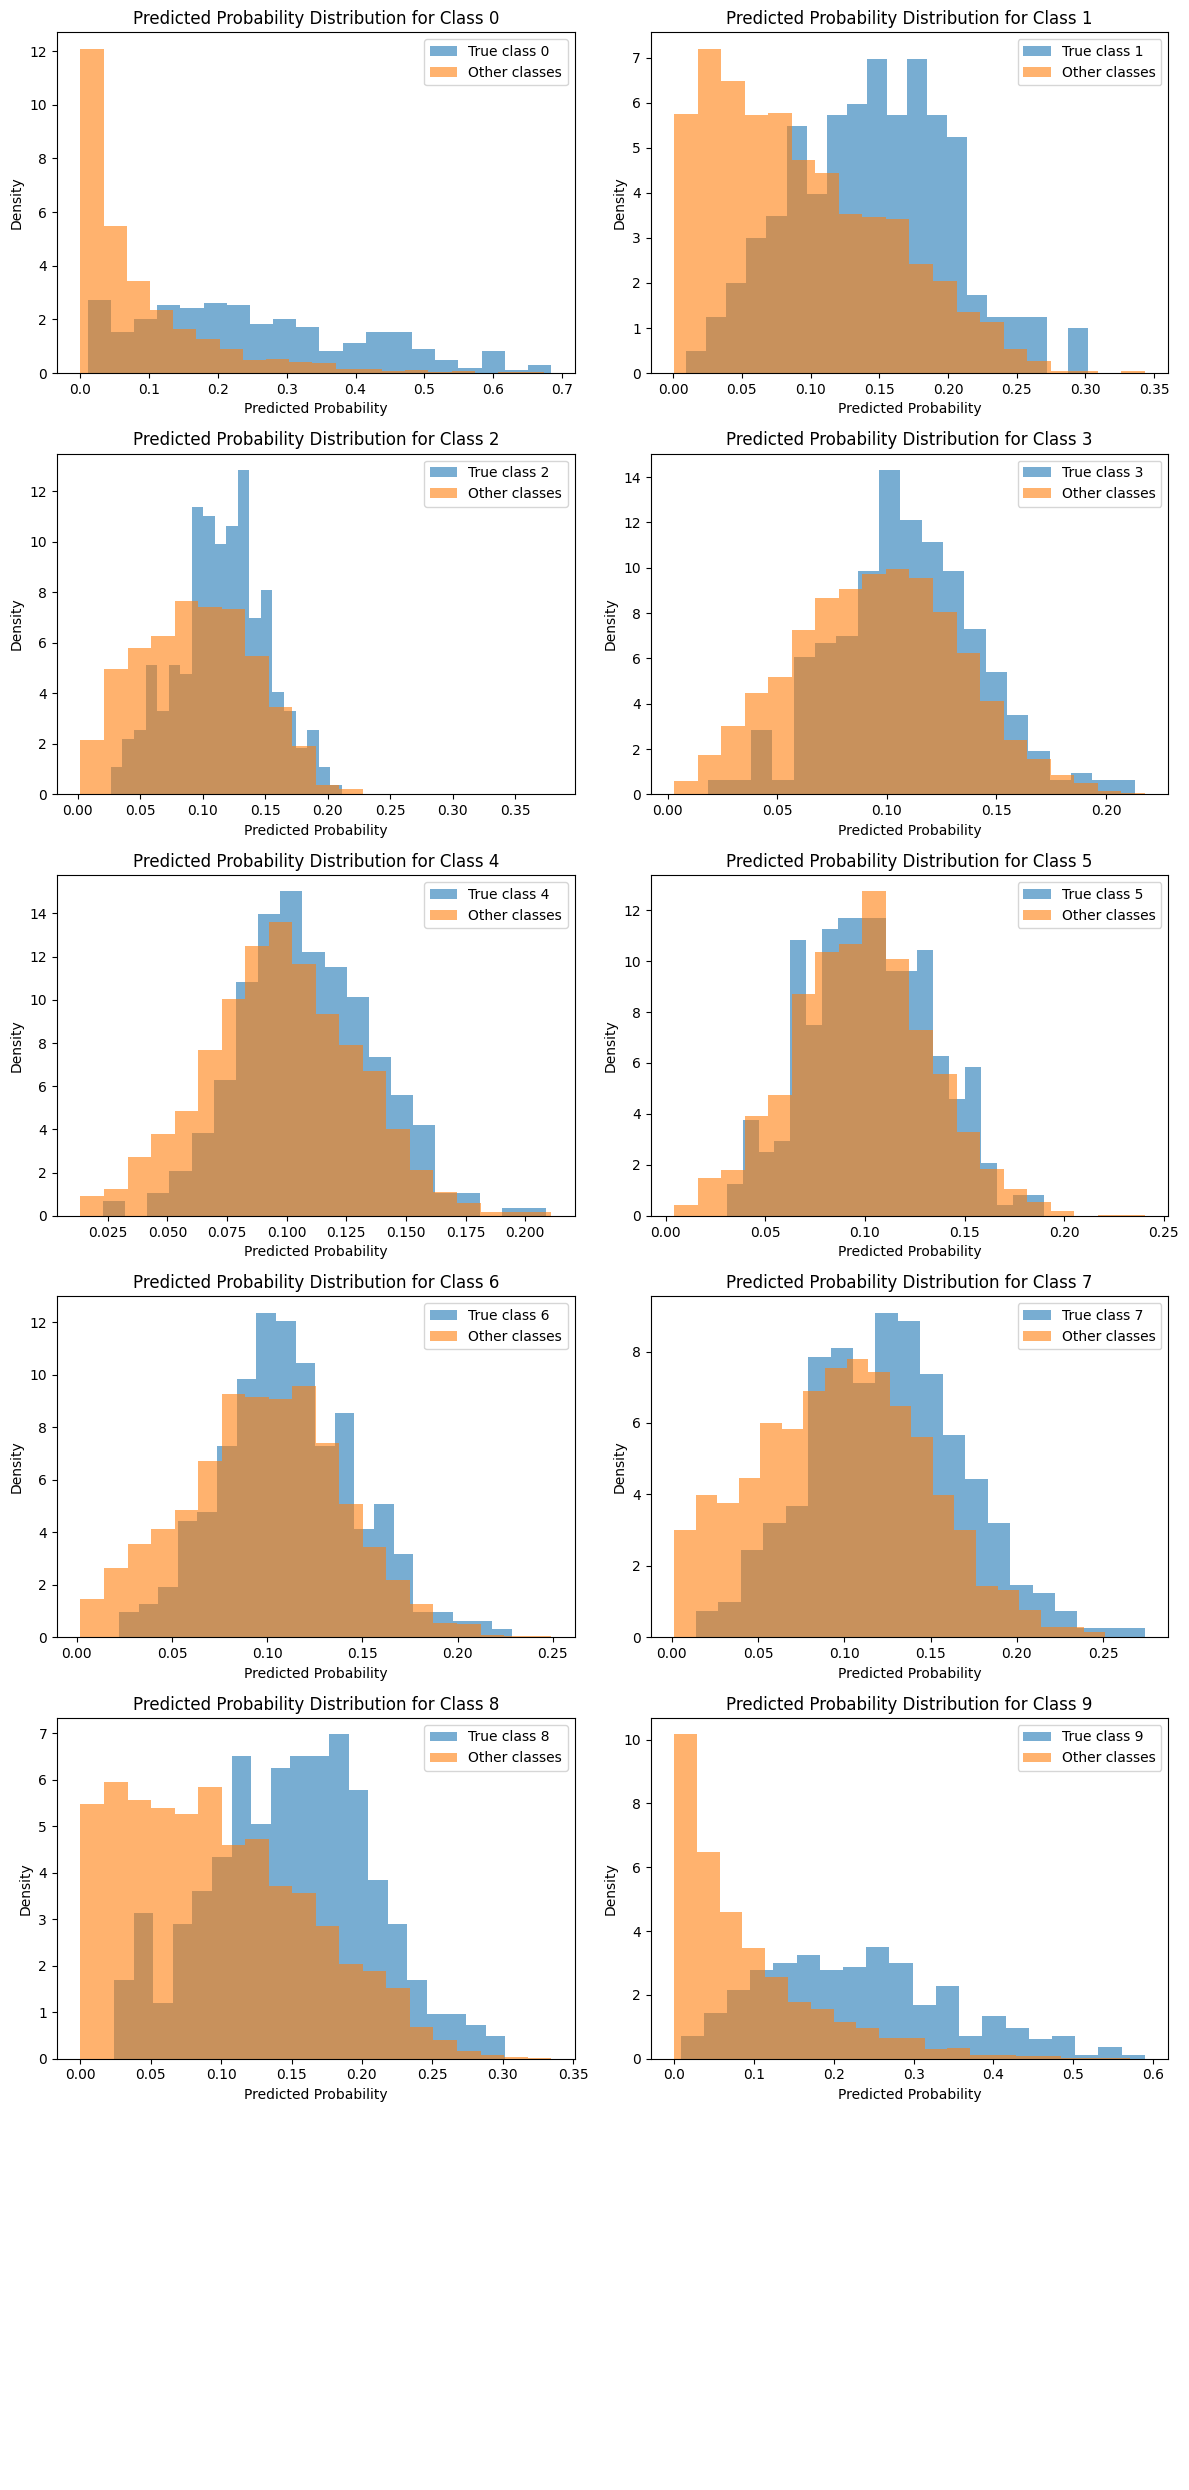

In [25]:
import matplotlib.pyplot as plt
import numpy as np

n_classes = p_pred_mean.shape[1]
fig, axes = plt.subplots(n_classes // 2 + 1, 2, figsize=(12, n_classes * 2.5))
axes = axes.flatten()

for cls in range(n_classes):
    ax = axes[cls]
    # Probabilities for true class = cls vs others
    true_class_probs = p_pred_mean[y_test == cls, cls]
    other_class_probs = p_pred_mean[y_test != cls, cls]

    ax.hist(true_class_probs, bins=20, density=True, alpha=0.6, label=f'True class {cls}')
    ax.hist(other_class_probs, bins=20, density=True, alpha=0.6, label=f'Other classes')
    ax.set_title(f'Predicted Probability Distribution for Class {cls}')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.legend()

# Hide any extra empty subplots
for ax in axes[n_classes:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


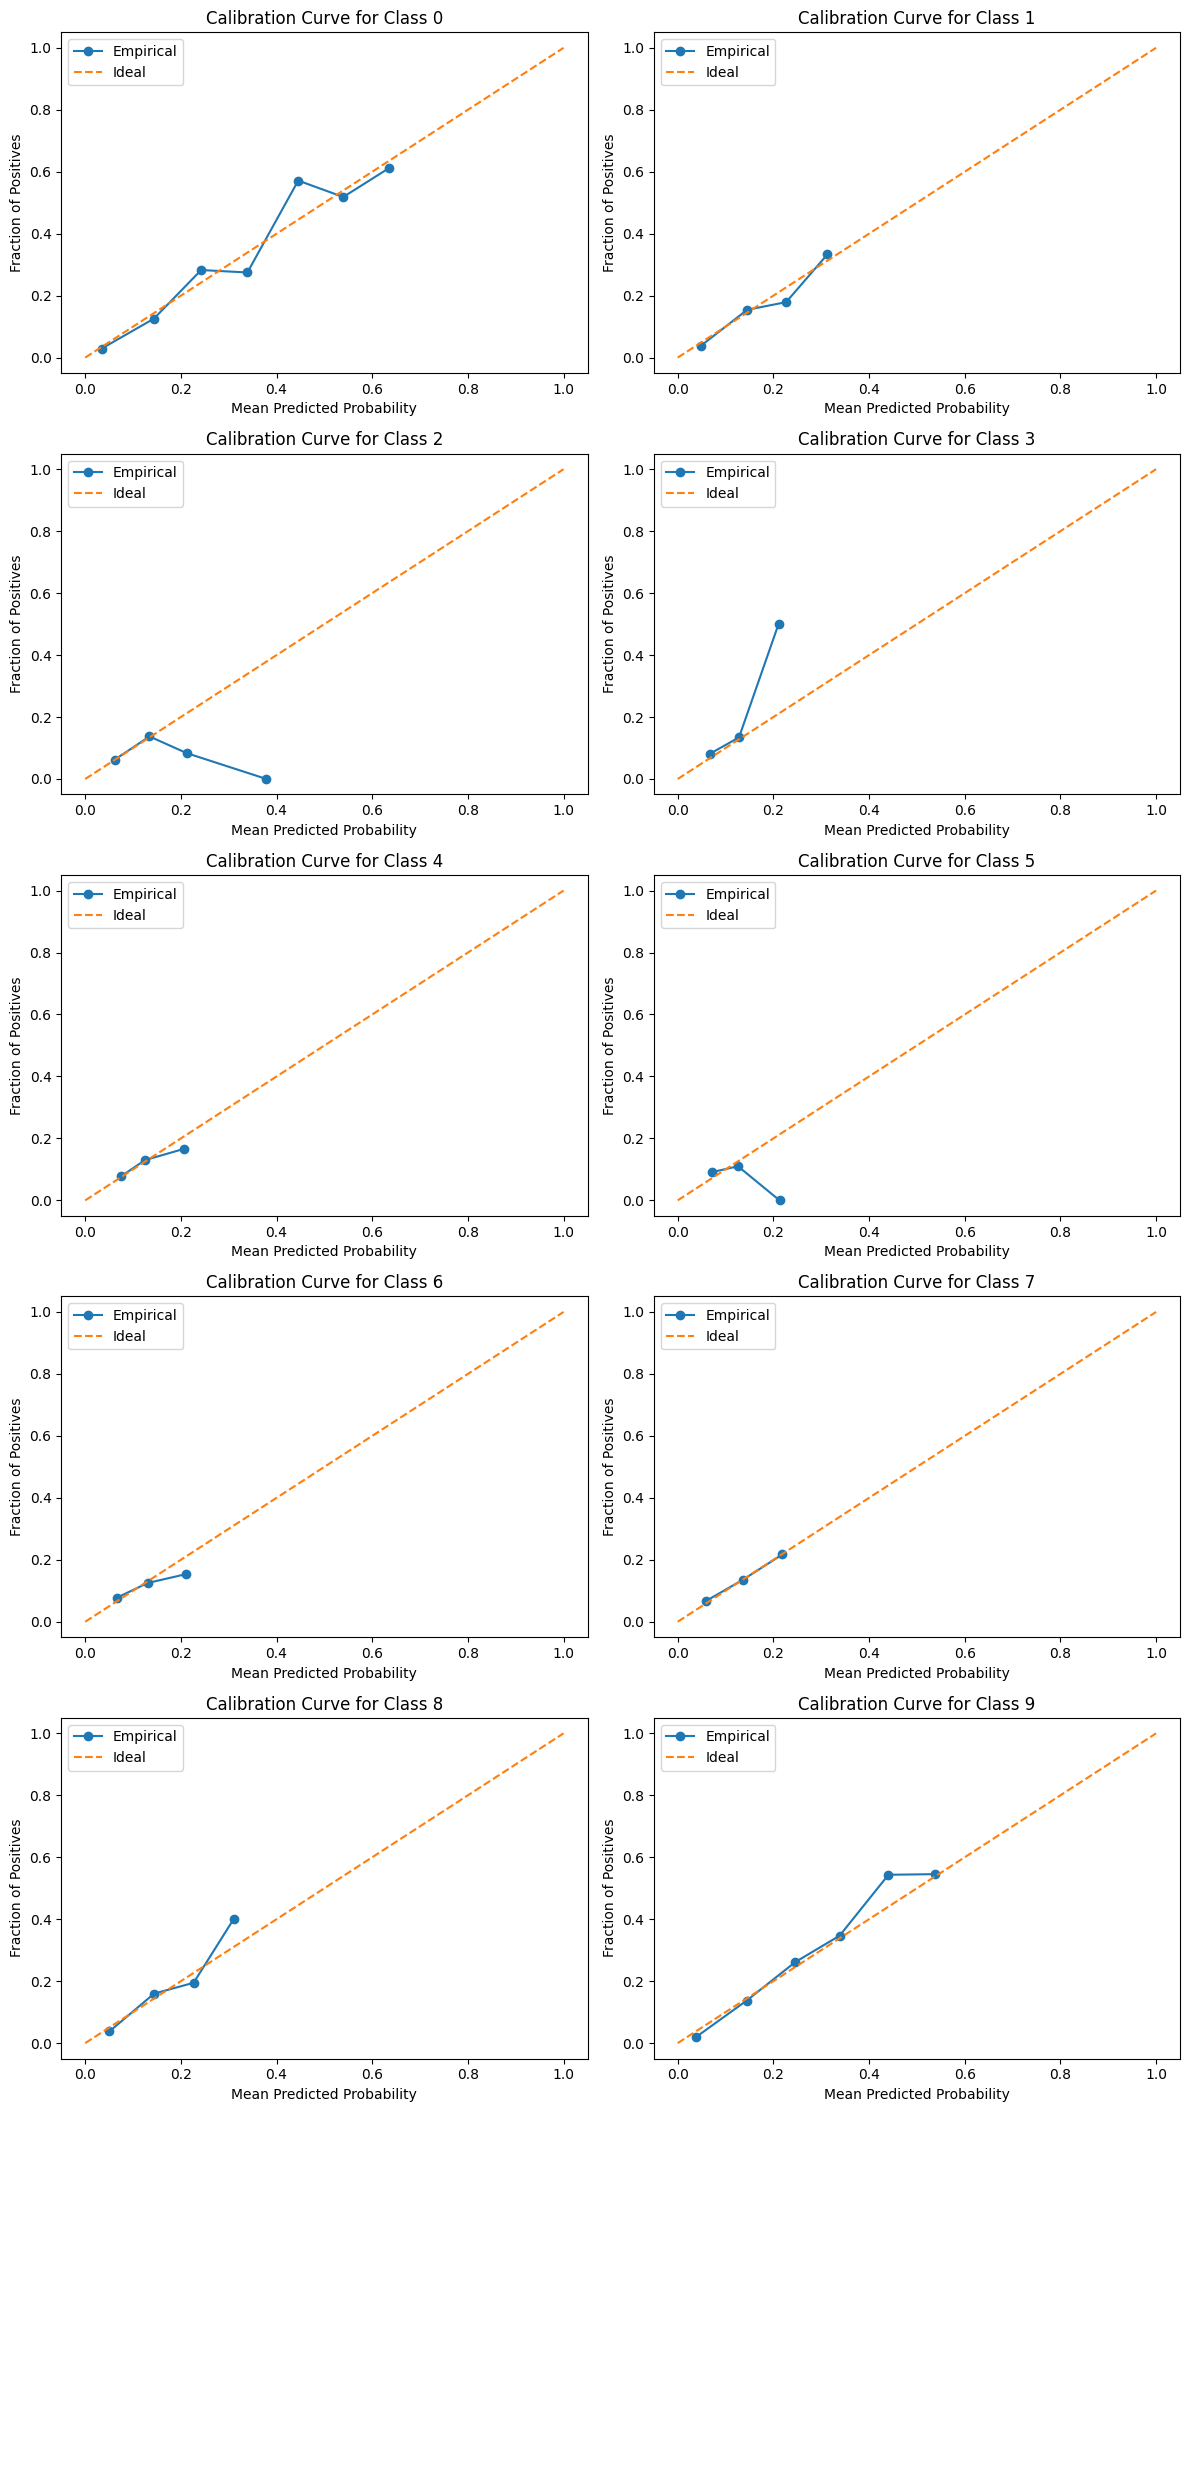

In [26]:
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(n_classes // 2 + 1, 2, figsize=(12, n_classes * 2.5))
axes = axes.flatten()

# Binarize true labels for each class
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

for cls in range(n_classes):
    ax = axes[cls]
    prob_true, prob_pred = calibration_curve(y_test_bin[:, cls], p_pred_mean[:, cls], n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label='Empirical')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
    ax.set_title(f'Calibration Curve for Class {cls}')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.legend()

# Hide unused plots
for ax in axes[n_classes:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


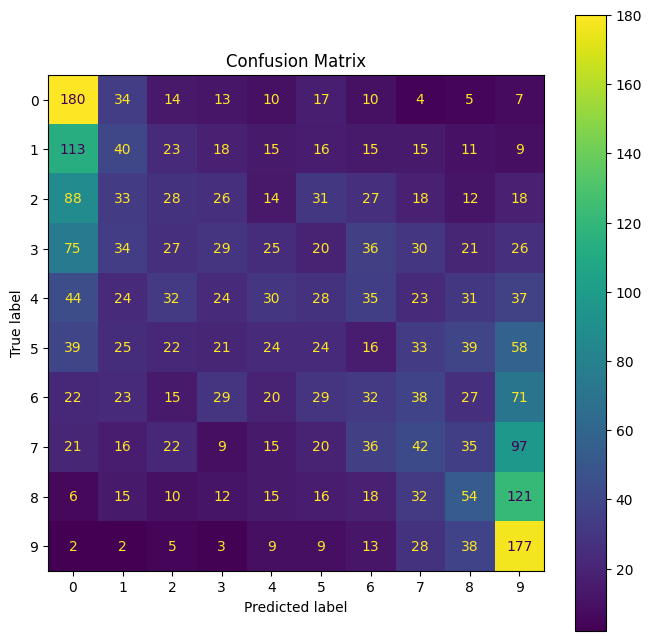

Accuracy: 0.212


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_pred = np.argmax(p_pred_mean, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.show()

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
